In [96]:
import h5py
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_theme(context='paper',style='white',palette=sns.color_palette("bright"),font_scale=1.5,font='serif')


def image_extraction(filename:str) -> tuple[np.array, pd.DataFrame]:
    """Extract images aswell as the foldless dataset. The indeces will match between ds and image array, but not ID."""
    dataset = h5py.File(filename, 'r')
    ds = pd.DataFrame()
    for i, fold in enumerate(dataset.keys()):
        df=pd.DataFrame({'ID':np.array(dataset[fold]['patient_idx']),'target':np.array(dataset[fold]['y']),'diagnosis':np.array(dataset[fold]['diagnosis']),'fold':i})
        ds=pd.concat([ds,df],ignore_index=True,axis=0,keys=['','fold {}'.format(fold)]) # ignore index to match index with image indeces
    #ds.set_index("ID", inplace = True)
    images=np.array(dataset['fold_0']['x'])
    images = np.append(images,np.array(dataset['fold_1']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_2']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_3']['x']),axis=0)
    images=images.reshape(len(images),800,800)
    dataset.close()
    return images, ds


def test_result_extraction(filename):
    """Make dataframe of prediction."""
    f = h5py.File(filename, 'r')
    pred = np.array(f['predicted'][:])
    patient = np.array(f['patient_idx'][:])
    y = np.array(f['y'][:]).argmax(axis=1)
    f.close()

    df = pd.DataFrame({'pred':pred.argmax(axis=1),'label': y},index=patient)

    df['prob']=np.round(np.round(pred.max(axis=1),2),2)
    df['pred']=np.round(df['pred'],0)
    df['label']=df['label']
    return df
       
def check_wrong(df, show_images=True, original_dataset=None, images=None):
    """
    df: the .h5 file of the test result
    """
    diagnoses=['normal','1, artrose/ sklerose','2, artrose', '2, MCD',
               '3, artrose', '3, MCD', '3, OCD', '3, UAP']
    wrong=df.iloc[np.where(df['pred'].values!=df['label'])[0]].index

    cm=sklearn.metrics.ConfusionMatrixDisplay.from_predictions(df['pred'],df['label'],normalize='true');
    plt.figure()
    sns.heatmap(cm.confusion_matrix,annot=True)
    plt.xticks([0.5,1.5,2.5],['Nivå 1','Nivå 2','Nivå 3'])
    plt.yticks([0.5,1.5,2.5],['Nivå 1','Nivå 2','Nivå 3'])
    plt.title('Normalisert forvirringsmatrise') #(normalisert over sann diagnose)
    plt.xlabel('Predikert klasse')
    plt.ylabel('Sann klasse')
    plt.show()

    df['result']= 'Correct'
    df.loc[wrong,('result')] = 'Wrong'
    df_wrong = df[df.result=='Wrong']
    df_wrong.loc[df_wrong.label==0,"label"]="Nivå 1"
    df_wrong.loc[df_wrong.label==1,"label"]="Nivå 2"
    df_wrong.loc[df_wrong.label==2,"label"]="Nivå 3"

    plt.figure()
    sns.stripplot(data=df_wrong,x='pred',y='prob',jitter=True,hue='label')
    plt.legend(title='Sann klasse',loc='right', bbox_to_anchor=(1.2, 0.2),
            ncol=1, fancybox=True)
    sns.violinplot(x=df_wrong['pred'],y=df_wrong['prob'],color="0.8",scale="count")
    plt.xticks([0,1,2],['Nivå 1','Nivå 2','Nivå 3'])
    plt.xlabel('Predikert klasse')
    plt.ylabel('Predikert sannsynlighet')
    plt.yticks(np.arange(0.4,1.1,0.2))
    plt.show()

    plt.figure()
    sns.stripplot(data=df[df['result']=='Correct'],x='pred',y='prob',jitter=True,hue='label')
    sns.violinplot(data=df[df['result']=='Correct'],x='pred',y='prob',color="0.8",scale="count")
    plt.xticks([0,1,2],['Nivå 1','Nivå 2','Nivå 3'])
    plt.xlabel('Predikert klasse')
    plt.ylabel('Predikert sannsynlighet')
    plt.yticks(np.arange(0.4,1.1,0.2))
    plt.legend([],[], frameon=False) # Remove legend, but keep hue colors
    plt.show()

    # plt.figure()
    # plt.title('Prøver feilklassifisert som nivå 1')
    # sns.histplot(df_wrong[df_wrong.pred==0], x='prob', bins=100, hue='label',stat="proportion",palette="dark")
    # plt.show()

    # plt.figure()
    # plt.title('Prøver feilklassifisert som nivå 2')
    # sns.histplot(df_wrong[df_wrong.pred==1], x='prob', bins=100, stat="proportion",hue='label',palette="dark")
    # plt.show()

    # plt.figure()
    # plt.title('Prøver feilklassifisert som nivå 3')
    # sns.histplot(df_wrong[df_wrong.pred==2], x='prob', bins=100, stat="proportion",hue='label')
    # plt.show()
    
    plt.figure()
    plt.title('Rett predikerte prøver')
    sns.histplot(df[df['result']=='Correct'], x='prob', stat="proportion",bins=100,hue="label",palette="bright")
    plt.show()

    plt.figure()
    sns.histplot(x=df.pred.loc[wrong].astype(str),data=df.loc[wrong],stat="proportion")
    plt.title('Fordeling av feilpredikerte i hvert nivå. \n (hvor mange ble feilpredikert som nivå 1, 2 og 3)')
    plt.xticks([0,1,2],['Nivå 1','Nivå 2','Nivå 3'])
    plt.show()

    plt.figure()
    sns.histplot(x=df.label.loc[wrong].astype(str),data=df.loc[wrong],stat="proportion")
    plt.title('Fordeling av feilpredikerte i hvert nivå. \n (hvor mange fra nivå 1, 2 og 3 ble predikert som noe annet)')
    plt.xticks([0,1,2],['Nivå 1','Nivå 2','Nivå 3'])
    plt.show()

    result_list=[]
    for i in wrong:
        if original_dataset is not None:
            result_list.append('ID: {}, prob: {:.2f}, True: {}'.format(original_dataset[original_dataset.ID==i].index[0],
                                                                    df.prob[i],
                                                                    original_dataset.diagnosis[original_dataset.ID==i].values[0]))
        if show_images==True:
            plt.figure()
            plt.imshow(images[original_dataset[original_dataset.ID==i].index[0]],'gray')
            plt.axis('off')
            plt.title('ID: {}, True: {}, Predicted: {:.2f} class {}'.format(original_dataset[original_dataset.ID==i].index[0],
                                                                    diagnoses[int(original_dataset.diagnosis[original_dataset.ID==i].values[0])],
                                                                    df.prob[i],df.pred[i]))
            plt.show()

    return df_wrong

In [2]:
images, ds = image_extraction('//nmbu.no/Research/Project/CubiAI/preprocess/datasets/800_level_3.h5')
df = test_result_extraction('prediction11856581.h5')


In [91]:
df['result']= 'Correct'
wrong=df.iloc[np.where(df['pred'].values!=df['label'])[0]].index
df.loc[wrong,('result')] = 'Wrong'
df_wrong = df[df.result=='Wrong']
#df_wrong.loc[df_wrong.label==0,"label"]="Nivå 1"
#df_wrong.loc[df_wrong.label==1,"label"]="Nivå 2"
#df_wrong.loc[df_wrong.label==2,"label"]="Nivå 3"



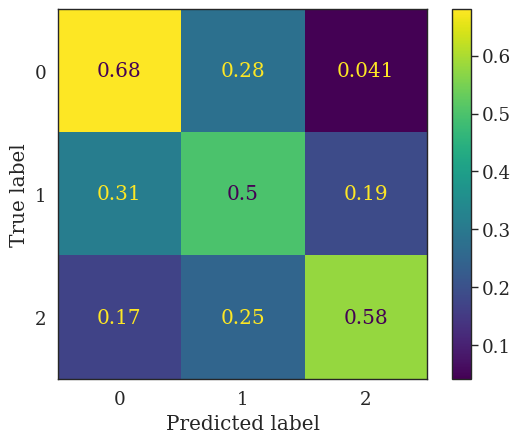

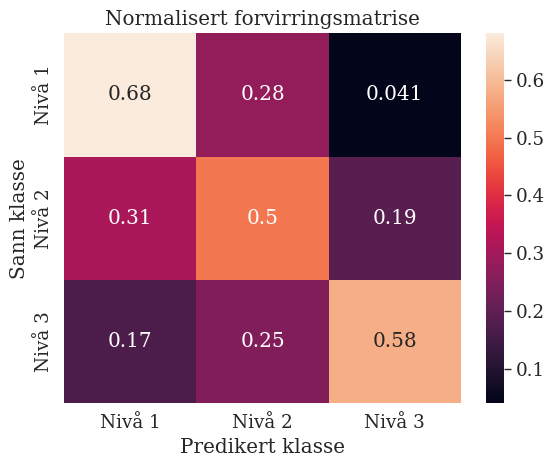

C:\NMBU\TEMP\ipykernel_9440\3437522844.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wrong.loc[df_wrong.label==0,"label"]="Nivå 1"


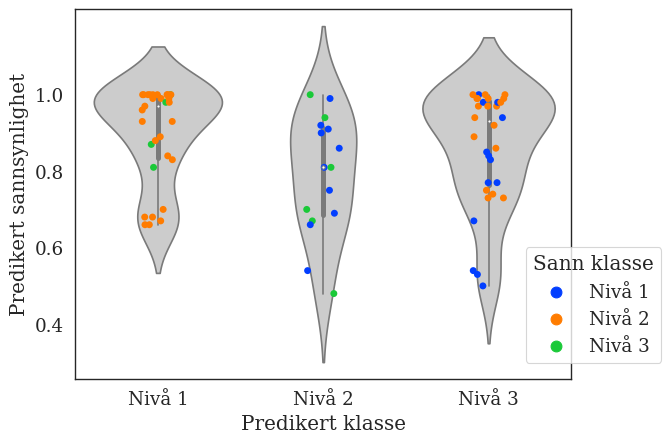

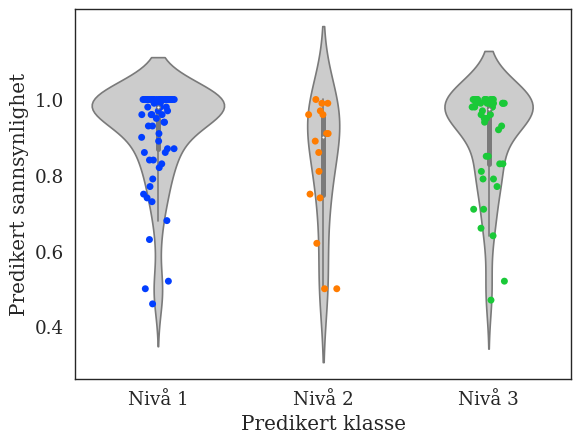

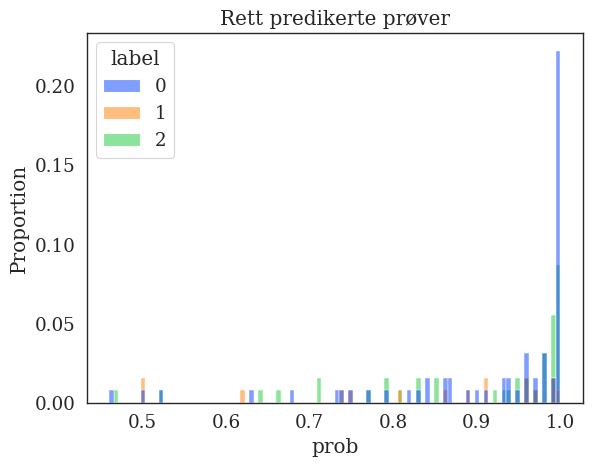

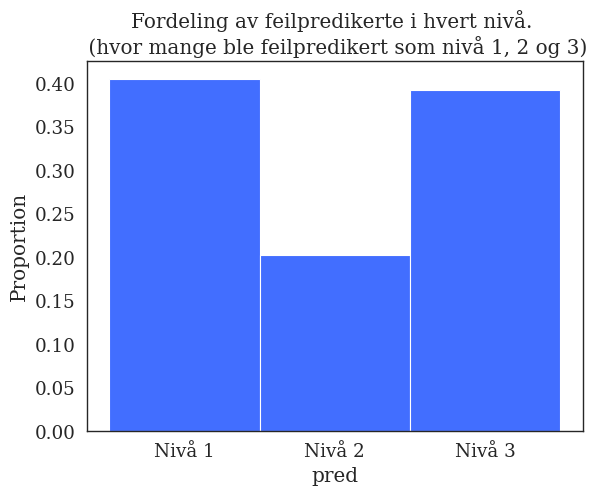

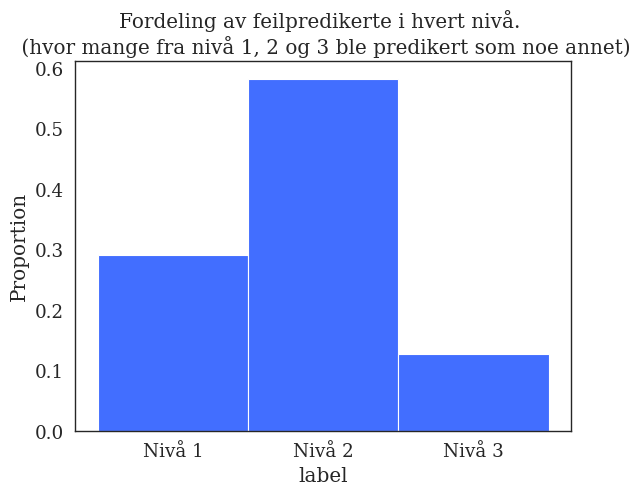

In [97]:
l=check_wrong(df,show_images=False, original_dataset=ds,images=images)